In [106]:
import pandas as pd
import numpy as np
from sklearn.svm import SVR
import matplotlib.pyplot as plt
from datetime import datetime, date, timedelta
from sklearn.metrics import mean_squared_error, r2_score, explained_variance_score

path = 'C:/Users/Thunyavut/Desktop/Finance-Made-Easy-Personalized-Planner/Python_script/ssf_nav_data'
file = 'M0152_2564_SSF.csv'
df = pd.read_csv(f'{path}/{file}')
df

,nav_date,net_asset,last_val,sell_price,buy_price,sell_swap_price,buy_swap_price
0,2021-08-20,5516762.81,10.0237,0.0000,0.0000,0.0000,0.0000
1,2021-08-23,5629591.69,10.2287,0.0000,0.0000,0.0000,0.0000
2,2021-08-24,5682142.05,10.3242,0.0000,0.0000,0.0000,0.0000
3,2021-08-25,5670374.66,10.3028,0.0000,0.0000,0.0000,0.0000
4,2021-08-26,5587672.35,10.1525,0.0000,0.0000,0.0000,0.0000
...,...,...,...,...,...,...,...
321,2022-12-26,289646.67,3.6042,0.0000,0.0000,0.0000,0.0000
322,2022-12-27,285818.20,3.5566,3.5567,3.5566,3.5566,3.5567
323,2022-12-28,284876.64,3.5294,3.5295,3.5294,3.5294,3.5295
324,2022-12-29,312851.43,3.6679,3.6680,3.6679,3.6679,3.6680


In [107]:
df['nav_date'] = pd.to_datetime(df['nav_date'], format = '%Y-%m-%d')

In [108]:
df1 = df.groupby(df['nav_date'].dt.strftime('%Y-%m'))['last_val'].mean().reset_index()

In [109]:
df1

,nav_date,last_val
0,2021-08,10.269050
1,2021-09,10.149748
2,2021-10,10.031038
3,2021-11,9.489814
4,2021-12,8.171775
5,2022-01,7.049820
6,2022-02,6.476111
7,2022-03,5.959765
8,2022-04,5.655288
9,2022-05,4.522458


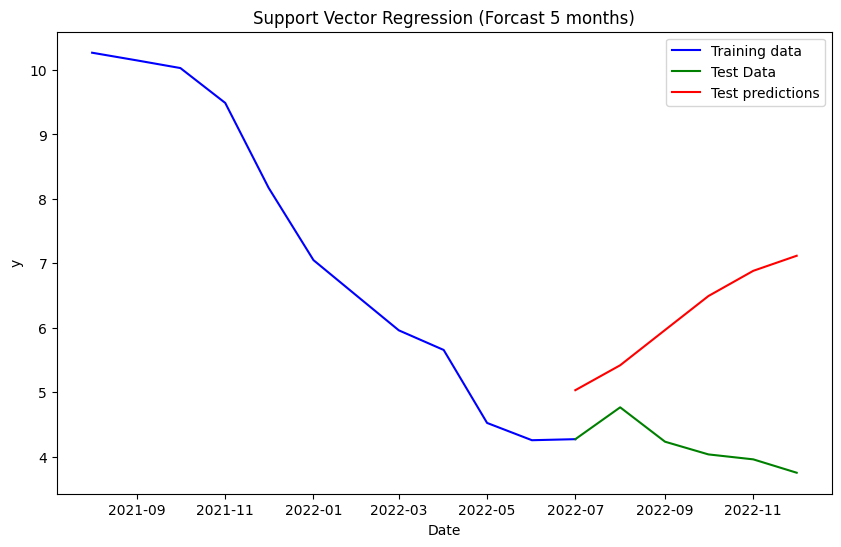

RMSE (Testing): 2.2344922762421096


,Date,Test
0,2022-07,4.270439
1,2022-08,4.764818
2,2022-09,4.231245
3,2022-10,4.033967
4,2022-11,3.957200
5,2022-12,3.749740


In [110]:
from sklearn.model_selection import GridSearchCV
start_date = pd.to_datetime(df1['nav_date']).min()
df1['nav_date']=pd.to_datetime(df1['nav_date'], format = '%Y-%m')
df1['months_since_start'] = (df1['nav_date'] - start_date).dt.days // 30  # Approximate months

# Prepare the features (X) and target (y)
X = np.array(df1['months_since_start']).reshape(-1, 1)
y = np.array(df1['last_val']).reshape(-1, 1)

# Split the data into training and testing sets
train_size = int(len(X) * 0.5)
X_train, X_test = X[:-5], X[-6:]
y_train, y_test = y[:-5], y[-6:]

y_train = y_train.ravel()
y_test = y_test.ravel()

# Create and train the SVR model
svr = SVR(kernel='rbf', gamma='scale')
svr.fit(X_train, y_train)

# Make predictions on the training and testing set
y_train_pred = svr.predict(X_train)
y_test_pred = svr.predict(X_test)

# Convert months_since_start back to datetime for plotting
dates_train = [start_date + pd.DateOffset(months=int(x)) for x in X_train]
dates_test = [start_date + pd.DateOffset(months=int(x)) for x in X_test]


# Plot the results
plt.figure(figsize=(10, 6))
plt.plot(dates_train, y_train, color='b', label='Training data')
#plt.plot(dates_train, y_train_pred, color='m', label='Training predictions')
plt.plot(dates_test, y_test, color='g', label='Test Data')
plt.plot(dates_test, y_test_pred, color='r', label='Test predictions')
plt.xlabel('Date')
plt.ylabel('y')
plt.title('Support Vector Regression (Forcast 5 months)')
plt.legend()
plt.show()

# Evaluate the model (RMSE for testing data)
mse_test = mean_squared_error(y_test, y_test_pred)
rmse_test = np.sqrt(mse_test)
print("RMSE (Testing):", rmse_test)

# Print the test data and predicted data
x= pd.DataFrame({'Date':dates_test, 'Test':y_test.flatten(), 'Predicted':y_test_pred.flatten()})

x1 = x.groupby(x['Date'].dt.strftime('%Y-%m'))['Test'].mean().reset_index()

x1

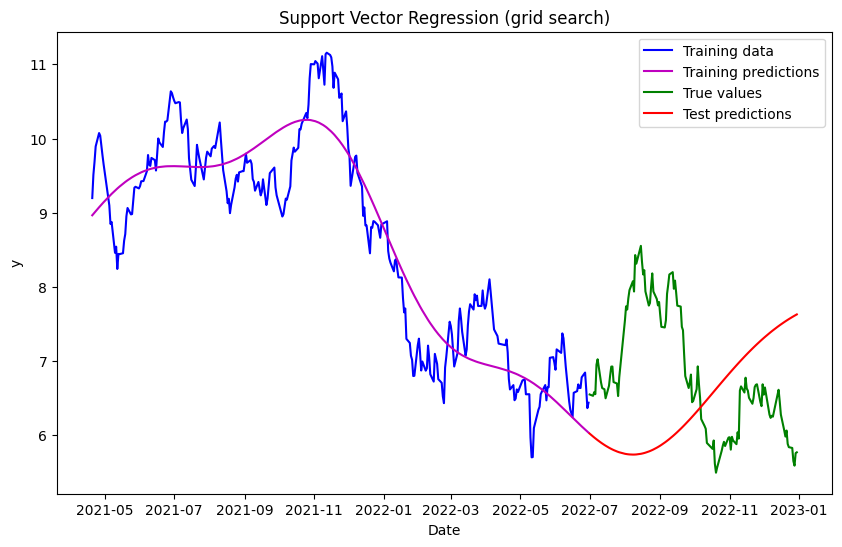

Best parameters: {'C': 20, 'epsilon': 1, 'gamma': 'scale'}
RMSE (Testing): 0.5630411872780234(3 days), 0.7709146793472867(7 days), 0.8378857600742696(14 days), 1.0708567237401896(21 days), 1.6111233006940804(30 days)


,Date,Test,Predicted
0,2022-07-01,6.5505,6.023124
1,2022-07-04,6.5325,5.984054
2,2022-07-05,6.5815,5.971478
3,2022-07-06,6.5547,5.959142
4,2022-07-07,6.9513,5.947057
...,...,...,...
117,2022-12-26,5.8299,7.594513
118,2022-12-27,5.6532,7.603562
119,2022-12-28,5.5917,7.612447
120,2022-12-29,5.7608,7.621168


In [39]:
from sklearn.model_selection import GridSearchCV

# Define the parameter grid for grid search
param_grid = {
    'C': [0.05, 0.1, 0.5, 1, 5, 10, 15, 20, 25, 30],
    'epsilon': [0.005, 0.01, 0.05, 0.1, 0.5, 1],
    'gamma': ['scale', 'auto'],
}

# Create the SVR model and perform grid search
svr = SVR(kernel='rbf')
grid_search = GridSearchCV(svr, param_grid, cv=10)
grid_search.fit(X_train, y_train)

# Get the best SVR model from grid search
best_svr = grid_search.best_estimator_

# Make predictions on the training and testing sett
y_train_pred = best_svr.predict(X_train)
y_test_pred = best_svr.predict(X_test)

# Convert timestamps back to dates for plotting
dates_train = [start_date + timedelta(days=int(x)) for x in X_train]
dates_test = [start_date + timedelta(days=int(x)) for x in X_test]

# Plot the results
plt.figure(figsize=(10, 6))
plt.plot(dates_train, y_train, color='b', label='Training data')
plt.plot(dates_train, y_train_pred, color='m', label='Training predictions')
plt.plot(dates_test, y_test, color='g', label='True values')
plt.plot(dates_test, y_test_pred, color='r', label='Test predictions')
plt.xlabel('Date')
plt.ylabel('y')
plt.title('Support Vector Regression (grid search)')
plt.legend()
plt.show()

# Evaluate the model
mse_test3 = mean_squared_error(y_test[0:3], y_test_pred[0:3])
rmse_test3 = np.sqrt(mse_test3)
mse_test7 = mean_squared_error(y_test[0:7], y_test_pred[0:7])
rmse_test7 = np.sqrt(mse_test7)
mse_test14 = mean_squared_error(y_test[0:14], y_test_pred[0:14])
rmse_test14 = np.sqrt(mse_test14)
mse_test21 = mean_squared_error(y_test[0:21], y_test_pred[0:21])
rmse_test21 = np.sqrt(mse_test21)
mse_test30 = mean_squared_error(y_test[0:30], y_test_pred[0:30])
rmse_test30 = np.sqrt(mse_test30)

# Print rmse
print("Best parameters:", grid_search.best_params_)
print("RMSE (Testing): {}(3 days), {}(7 days), {}(14 days), {}(21 days), {}(30 days)".format(rmse_test3,rmse_test7,rmse_test14,rmse_test21,rmse_test30))

# Print the test data and predicted data
x= pd.DataFrame({'Date':dates_test, 'Test':y_test.flatten(), 'Predicted':y_test_pred.flatten()})
x

In [17]:
#x.to_csv("SVR model.csv", index = True, header=True) 

In [40]:
x.to_csv('SVR model.csv', mode='a', index = True, header=True)

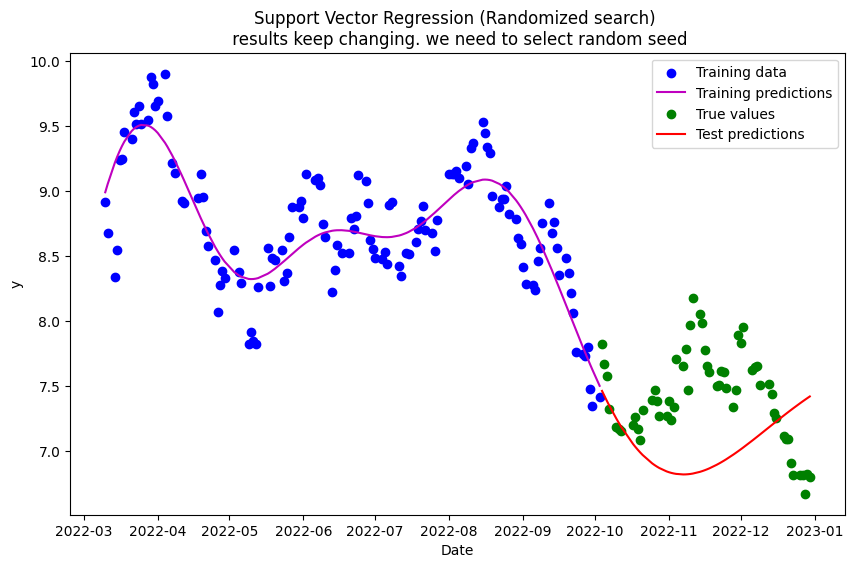

Best parameters: {'C': 10, 'epsilon': 0.5, 'gamma': 'scale'}
RMSE (Testing): 0.6025259049962632


,Date,Test,Predicted
0,2022-10-04,7.8230,7.463703
1,2022-10-05,7.6705,7.425558
2,2022-10-06,7.5804,7.388430
3,2022-10-07,7.3264,7.352358
4,2022-10-10,7.1878,7.250811
5,2022-10-11,7.1718,7.219276
6,2022-10-12,7.1579,7.188936
7,2022-10-17,7.2034,7.055643
8,2022-10-18,7.2613,7.032721
9,2022-10-19,7.1692,7.011050


In [7]:
from sklearn.model_selection import RandomizedSearchCV, KFold

# Define the parameter grid for randomized search
param_grid = {
    'C': [0.05, 0.1, 1, 10],
    'epsilon': [0.01, 0.1, 0.5],
    'gamma': ['scale', 'auto'],
}

# Create the SVR model
svr = SVR()

# Perform randomized search with cross-validation
np.random.seed(1)
random_search = RandomizedSearchCV(svr, param_distributions=param_grid, n_iter=5, cv=KFold(n_splits=5, shuffle=True))
random_search.fit(X_train, y_train)

# Get the best SVR model from randomized search
best_svr = random_search.best_estimator_

# Make predictions on the training and testing set
y_train_pred = best_svr.predict(X_train)
y_test_pred = best_svr.predict(X_test)

# Convert timestamps back to dates for plotting
dates_train = [start_date + timedelta(days=int(x)) for x in X_train]
dates_test = [start_date + timedelta(days=int(x)) for x in X_test]

# Plot the results
plt.figure(figsize=(10, 6))
plt.scatter(dates_train, y_train, color='b', label='Training data')
plt.plot(dates_train, y_train_pred, color='m', label='Training predictions')
plt.scatter(dates_test, y_test, color='g', label='True values')
plt.plot(dates_test, y_test_pred, color='r', label='Test predictions')
plt.xlabel('Date')
plt.ylabel('y')
plt.title('Support Vector Regression (Randomized search) \n results keep changing. we need to select random seed')
plt.legend()
plt.show()

# Evaluate the model
mse_test = mean_squared_error(y_test, y_test_pred)
rmse_test = np.sqrt(mse_test)
    
# Print rmse
print("Best parameters:", grid_search.best_params_)
print("RMSE (Testing):", rmse_test)

# Print the test data and predicted data
x= pd.DataFrame({'Date':dates_test, 'Test':y_test.flatten(), 'Predicted':y_test_pred.flatten()})
x

In [8]:
from sklearn.model_selection import TimeSeriesSplit

def gradient_descent(X, y, learning_rate=5, num_iterations=5000):
    # Initialize the hyperparameters
    C = 10.0
    epsilon = 0.5

    # Perform gradient descent
    for _ in range(num_iterations):
        # Fit the SVR model with the current hyperparameters
        model = SVR(C=C, epsilon=epsilon)
        model.fit(X_train, y_train)

        # Compute the gradients of the hyperparameters
        grad_C = -2 * learning_rate * np.sum(model.dual_coef_)
        grad_epsilon = -2 * learning_rate * np.sum(model.dual_coef_)

        # Update the hyperparameters
        C -= grad_C
        epsilon -= grad_epsilon

    return C, epsilon

# Define your time series dataset (X) and corresponding target variable (y)

# Define the learning rate and number of iterations for gradient descent
learning_rate = 5
num_iterations = 5000

# Perform gradient-based hyperparameter tuning
best_C, best_epsilon = gradient_descent(X_train, y_train, learning_rate, num_iterations)

# Fit the final model using the best hyperparameters
final_model = SVR(C=best_C, epsilon=best_epsilon)
final_model.fit(X_train, y_train)

SVR(C=9.999999999999924, epsilon=0.4999999999999245)

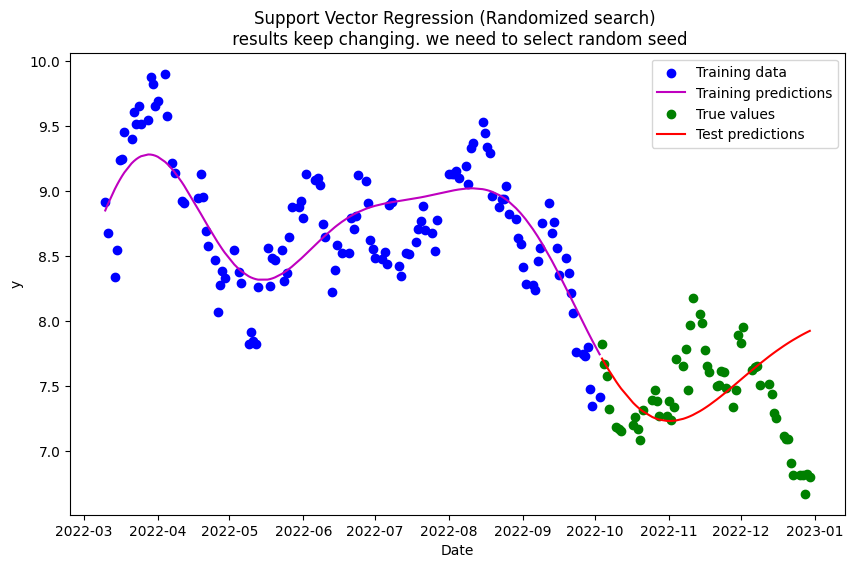

RMSE (Testing): 0.5036809626741967


,Date,Test,Predicted
0,2022-10-04,7.8230,7.712266
1,2022-10-05,7.6705,7.680164
2,2022-10-06,7.5804,7.648899
3,2022-10-07,7.3264,7.618521
4,2022-10-10,7.1878,7.533196
5,2022-10-11,7.1718,7.506833
6,2022-10-12,7.1579,7.481573
7,2022-10-17,7.2034,7.372834
8,2022-10-18,7.2613,7.354754
9,2022-10-19,7.1692,7.337931


In [9]:
# Make predictions on the training and testing set
y_train_pred = final_model.predict(X_train)
y_test_pred = final_model.predict(X_test)

# Convert timestamps back to dates for plotting
dates_train = [start_date + timedelta(days=int(x)) for x in X_train]
dates_test = [start_date + timedelta(days=int(x)) for x in X_test]

# Plot the results
plt.figure(figsize=(10, 6))
plt.scatter(dates_train, y_train, color='b', label='Training data')
plt.plot(dates_train, y_train_pred, color='m', label='Training predictions')
plt.scatter(dates_test, y_test, color='g', label='True values')
plt.plot(dates_test, y_test_pred, color='r', label='Test predictions')
plt.xlabel('Date')
plt.ylabel('y')
plt.title('Support Vector Regression (Randomized search) \n results keep changing. we need to select random seed')
plt.legend()
plt.show()

# Evaluate the model
mse_test = mean_squared_error(y_test, y_test_pred)
rmse_test = np.sqrt(mse_test)
    
# Print rmse
print("RMSE (Testing):", rmse_test)

# Print the test data and predicted data
x= pd.DataFrame({'Date':dates_test, 'Test':y_test.flatten(), 'Predicted':y_test_pred.flatten()})
x